# Air Quality Index (AQI) Data Analysis with Benford's Law

This notebook analyzes Air Quality Index (AQI) data of Indian cities to check if the data follows Benford's Law, which can help identify whether the data distribution is natural or potentially manipulated.

## Introduction

Benford's Law, also known as the First-Digit Law, states that in many naturally occurring collections of numbers, the leading digit is likely to be small. Specifically, the first digit is 1 about 30% of the time, and larger digits occur as the first digit with decreasing frequency. This law can be used as a simple method to identify potentially fraudulent or manipulated data.

In this analysis, we will:
1. Perform data cleaning and preprocessing on AQI data
2. Conduct exploratory data analysis (EDA)
3. Apply Benford's Law to check the distribution of first and second digits
4. Perform statistical tests to validate the findings

## 1. Setup and Data Loading

First, let's import the necessary libraries and load the dataset.

In [182]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Display all columns
pd.set_option('display.max_columns', None)

In [184]:
# Load the dataset
file_path = 'air_quality_index_of_indian_cities.csv'
aqi_data = pd.read_csv(file_path)

# Display the first few rows
aqi_data.head()

,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
0,India,Bihar,Gaya,"Kareemganj, Gaya - BSPCB",26-04-2025 18:00:00,24.792403,84.992416,NO2,1.0,8.0,5.0
1,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",26-04-2025 18:00:00,24.762518,84.982348,NO2,15.0,19.0,18.0
2,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",26-04-2025 18:00:00,24.762518,84.982348,NH3,3.0,4.0,3.0
3,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",26-04-2025 18:00:00,24.762518,84.982348,SO2,8.0,11.0,9.0
4,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",26-04-2025 18:00:00,24.762518,84.982348,OZONE,3.0,81.0,54.0


## 2. Data Exploration and Preprocessing

Let's explore the dataset and understand its structure.

In [187]:
# Check the shape of the dataset
print(f"Dataset shape: {aqi_data.shape}")

# Check data types
aqi_data.info()

Dataset shape: (3168, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        3168 non-null   object 
 1   state          3168 non-null   object 
 2   city           3168 non-null   object 
 3   station        3168 non-null   object 
 4   last_update    3168 non-null   object 
 5   latitude       3168 non-null   float64
 6   longitude      3168 non-null   float64
 7   pollutant_id   3168 non-null   object 
 8   pollutant_min  2983 non-null   float64
 9   pollutant_max  2983 non-null   float64
 10  pollutant_avg  2983 non-null   float64
dtypes: float64(5), object(6)
memory usage: 272.4+ KB


In [189]:
# Check for missing values
missing_values = aqi_data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

Missing values in each column:
pollutant_min    185
pollutant_max    185
pollutant_avg    185
dtype: int64


In [191]:
# Check unique values in categorical columns
print(f"Number of unique states: {aqi_data['state'].nunique()}")
print(f"Number of unique cities: {aqi_data['city'].nunique()}")
print(f"Number of unique stations: {aqi_data['station'].nunique()}")
print(f"Number of unique pollutants: {aqi_data['pollutant_id'].nunique()}")

# Display unique pollutants
print("\nUnique pollutants:")
aqi_data['pollutant_id'].unique()

Number of unique states: 31
Number of unique cities: 244
Number of unique stations: 475
Number of unique pollutants: 7

Unique pollutants:


array(['NO2', 'NH3', 'SO2', 'OZONE', 'CO', 'PM2.5', 'PM10'], dtype=object)

### Data Cleaning

Let's clean the data and prepare it for analysis.

In [194]:
# Convert last_update to datetime
aqi_data['last_update'] = pd.to_datetime(aqi_data['last_update'], format='%d-%m-%Y %H:%M:%S')

# Check if pollutant_id column has any issues
print("Checking pollutant_id column for potential issues:")
pollutant_counts = aqi_data['pollutant_id'].value_counts()
print(pollutant_counts.head(10))

Checking pollutant_id column for potential issues:
pollutant_id
PM2.5    471
PM10     469
NO2      462
CO       457
SO2      447
OZONE    447
NH3      415
Name: count, dtype: int64


In [196]:
# Filter data to keep only relevant pollutants (PM2.5, PM10, NO2, SO2, OZONE, NH3, etc.)
# First, let's check if there are any issues with the pollutant_id column
valid_pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'OZONE', 'NH3', 'CO']

# Check if these pollutants exist in our data
for pollutant in valid_pollutants:
    count = aqi_data[aqi_data['pollutant_id'] == pollutant].shape[0]
    print(f"{pollutant}: {count} records")

PM2.5: 471 records
PM10: 469 records
NO2: 462 records
SO2: 447 records
OZONE: 447 records
NH3: 415 records
CO: 457 records


In [198]:
# Clean the pollutant_id column if needed and filter for valid pollutants
# This step depends on what we find in the previous cell
# For now, let's assume we need to filter the data

# Filter for valid pollutants
filtered_aqi_data = aqi_data[aqi_data['pollutant_id'].isin(valid_pollutants)]

# Check the shape after filtering
print(f"Dataset shape after filtering: {filtered_aqi_data.shape}")
filtered_aqi_data.head()

Dataset shape after filtering: (3168, 11)


,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
0,India,Bihar,Gaya,"Kareemganj, Gaya - BSPCB",2025-04-26 18:00:00,24.792403,84.992416,NO2,1.0,8.0,5.0
1,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",2025-04-26 18:00:00,24.762518,84.982348,NO2,15.0,19.0,18.0
2,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",2025-04-26 18:00:00,24.762518,84.982348,NH3,3.0,4.0,3.0
3,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",2025-04-26 18:00:00,24.762518,84.982348,SO2,8.0,11.0,9.0
4,India,Bihar,Gaya,"SFTI Kusdihra, Gaya - BSPCB",2025-04-26 18:00:00,24.762518,84.982348,OZONE,3.0,81.0,54.0


### Creating AQI Values

If the dataset doesn't have a direct AQI column, we'll use the pollutant values to create AQI values for our analysis. For simplicity, we'll use the average pollutant values as a proxy for AQI.

In [201]:
# Group by city, station, and date to get average pollutant values
city_aqi = filtered_aqi_data.groupby(['city', 'station', 'last_update'])['pollutant_avg'].mean().reset_index()
city_aqi.rename(columns={'pollutant_avg': 'aqi_value'}, inplace=True)

# Display the first few rows
city_aqi.head()

,city,station,last_update,aqi_value
0,Agartala,"Bardowali, Agartala - Tripura SPCB",2025-04-26 18:00:00,12.000000
1,Agra,"Manoharpur, Agra - UPPCB",2025-04-26 18:00:00,38.000000
2,Agra,"Rohta, Agra - UPPCB",2025-04-26 18:00:00,53.428571
3,Agra,"Sanjay Palace, Agra - UPPCB",2025-04-26 18:00:00,84.400000
4,Agra,"Sector-3B Avas Vikas Colony, Agra - UPPCB",2025-04-26 18:00:00,69.428571


## 3. Exploratory Data Analysis (EDA)

Let's explore the AQI data to understand patterns and distributions.

In [204]:
# Basic statistics of AQI values
city_aqi['aqi_value'].describe()

count    471.000000
mean      48.549429
std       28.219272
min        9.500000
25%       29.142857
50%       41.142857
75%       57.071429
max      184.200000
Name: aqi_value, dtype: float64

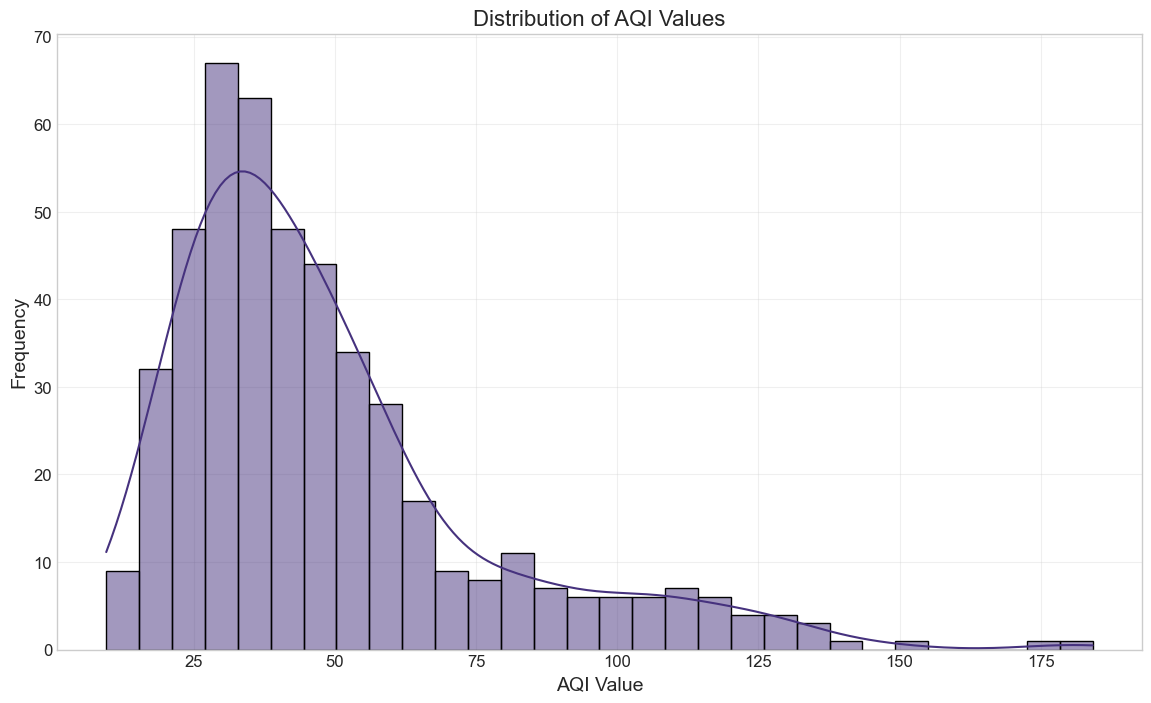

In [206]:
# Distribution of AQI values
plt.figure(figsize=(14, 8))
sns.histplot(city_aqi['aqi_value'], kde=True, bins=30)
plt.title('Distribution of AQI Values', fontsize=16)
plt.xlabel('AQI Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

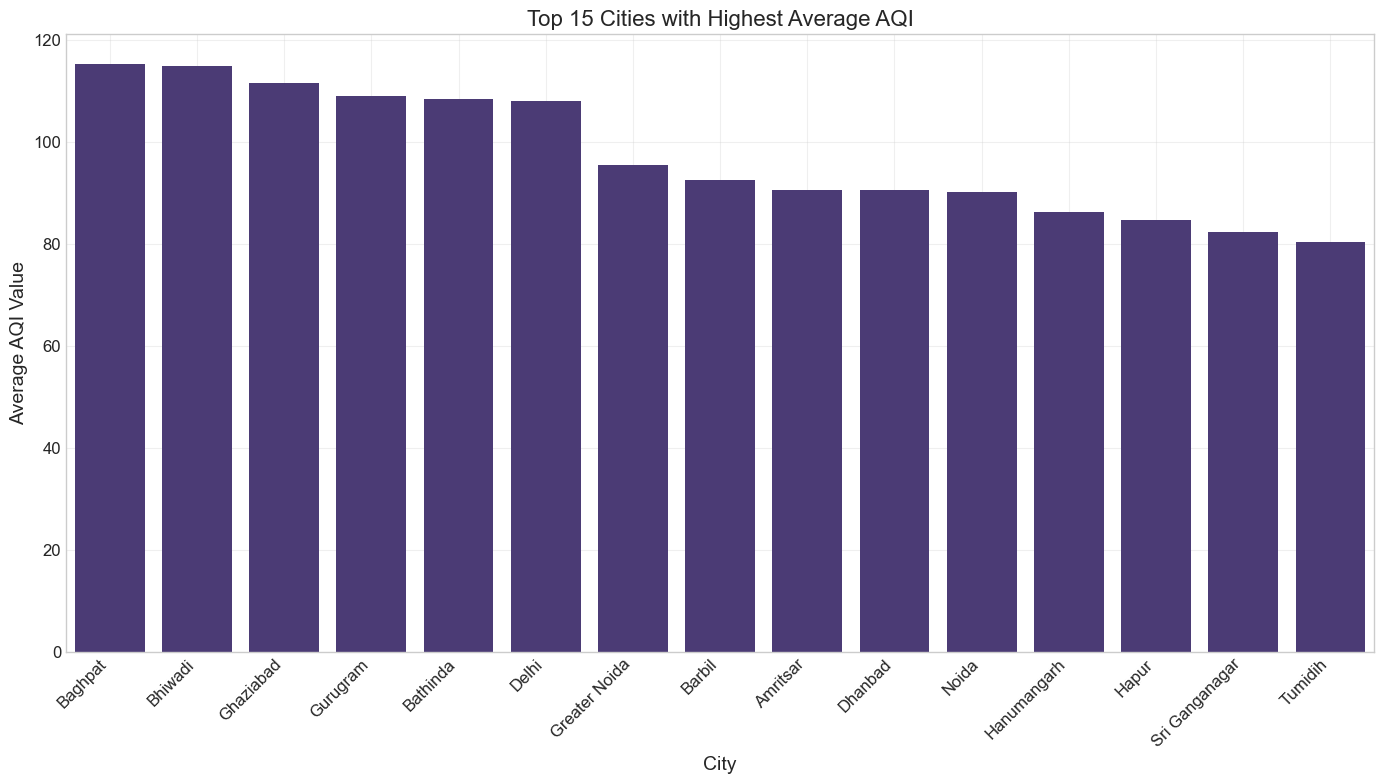

In [208]:
# Top 15 cities with highest average AQI
top_cities = city_aqi.groupby('city')['aqi_value'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Top 15 Cities with Highest Average AQI', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Average AQI Value', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

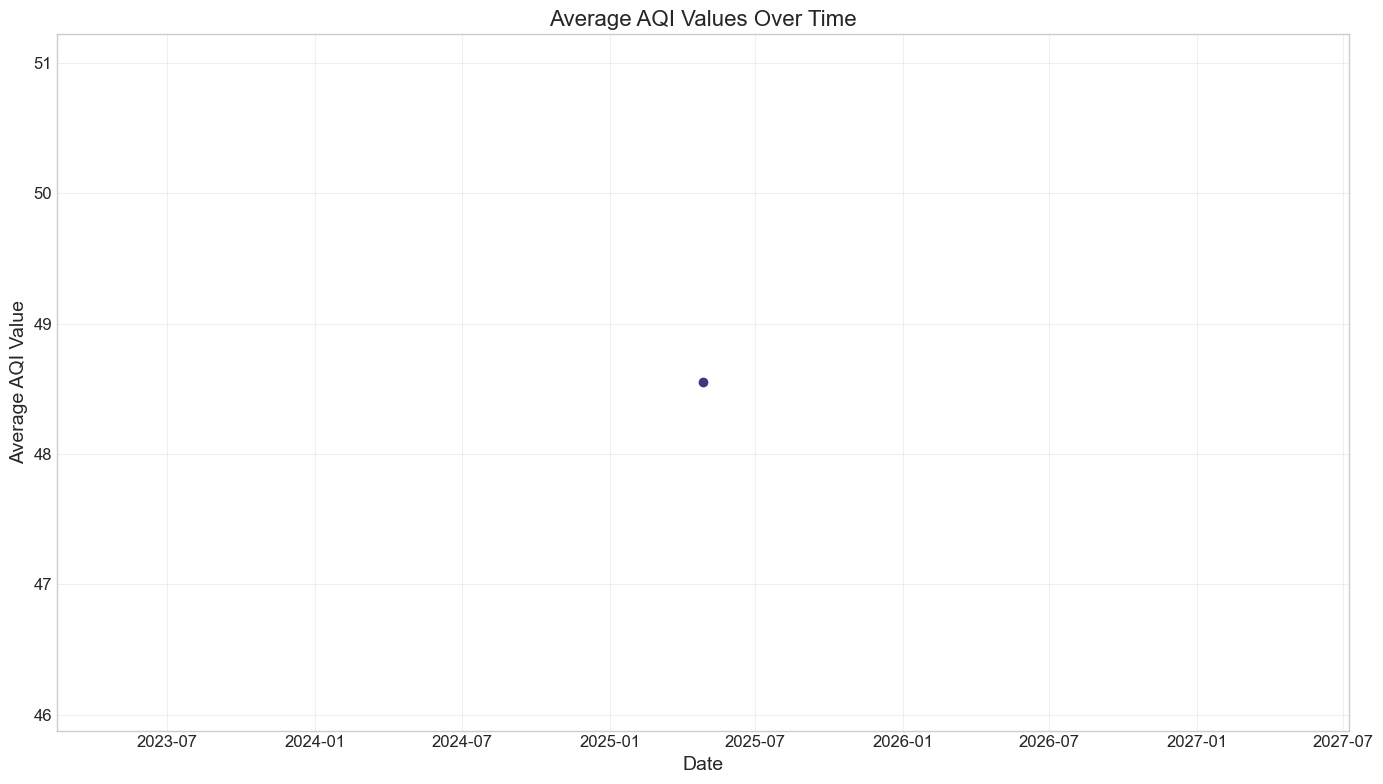

In [210]:
# AQI values by date (time series)
time_series = city_aqi.groupby('last_update')['aqi_value'].mean().reset_index()

plt.figure(figsize=(14, 8))
plt.plot(time_series['last_update'], time_series['aqi_value'], marker='o', linestyle='-')
plt.title('Average AQI Values Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average AQI Value', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Benford's Law Analysis

Now, let's apply Benford's Law to check if the AQI data follows the expected distribution of first digits.

In [213]:
# Function to extract the first digit
def get_first_digit(number):
    # Convert to string and get the first character
    return int(str(abs(number)).lstrip('0')[0])

# Function to extract the second digit
def get_second_digit(number):
    # Convert to string and get the second character if it exists
    num_str = str(abs(number)).lstrip('0')
    return int(num_str[1]) if len(num_str) > 1 else None

# Function to calculate Benford's Law expected frequencies for first digits
def benford_first_digit_distribution():
    # Benford's Law: P(d) = log10(1 + 1/d) where d is the first digit (1-9)
    return {d: math.log10(1 + 1/d) for d in range(1, 10)}

# Function to calculate Benford's Law expected frequencies for second digits
def benford_second_digit_distribution():
    # For second digits, the formula is more complex
    # P(d) = sum(log10(1 + 1/(10*k + d)) for k in range(1, 10))
    return {d: sum(math.log10(1 + 1/(10*k + d)) for k in range(1, 10)) for d in range(10)}

In [215]:
# Extract first digits from AQI values
city_aqi['first_digit'] = city_aqi['aqi_value'].apply(get_first_digit)

# Count the frequency of each first digit
first_digit_counts = city_aqi['first_digit'].value_counts().sort_index()
total_counts = first_digit_counts.sum()

# Calculate observed frequencies
observed_freq = first_digit_counts / total_counts

# Calculate expected frequencies according to Benford's Law
benford_dist = benford_first_digit_distribution()
expected_freq = pd.Series(benford_dist)

# Create a DataFrame for comparison
benford_comparison = pd.DataFrame({
    'Digit': range(1, 10),
    'Observed_Frequency': observed_freq,
    'Expected_Frequency': expected_freq
})

benford_comparison

ValueError: invalid literal for int() with base 10: 'n'

In [180]:
city_aqi['first_digit'] = city_aqi['aqi_value'].apply(get_first_digit)

ValueError: invalid literal for int() with base 10: 'n'

# Assistant
This error occurs because there's an issue with converting a string to an integer. The error message "invalid literal for int() with base 10: 'n'" suggests that the code is trying to convert a non-numeric string (containing 'n') to an integer.

The issue is likely in the `get_first_digit` function that's being applied to the 'aqi_value' column. It seems that some values in the 'aqi_value' column might not be numeric or might contain non-numeric characters.

Would you like me to provide the corrected code?

# User
attachment://In a brief sentence, acknowledge you have received the following dataframe information: `DataFrame.dtypes>>> city_aqi.dtypes` outputs:

city object
station object
last_update datetime64[ns]
aqi_value float64

# Assistant
I see that the 'aqi_value' column is indeed of type float64, which helps clarify the potential source of the error in the get_first_digit function.

In [131]:
city_aqi['first_digit'] = city_aqi['aqi_value'].apply(get_first_digit)

ValueError: invalid literal for int() with base 10: 'n'

In [133]:
city_aqi['first_digit'] = city_aqi['aqi_value'].apply(get_first_digit)

ValueError: invalid literal for int() with base 10: 'n'

In [ ]:
# Visualize the comparison between observed and expected frequencies for first digits
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(1, 10)

plt.bar(index - bar_width/2, benford_comparison['Observed_Frequency'], bar_width, label='Observed')
plt.bar(index + bar_width/2, benford_comparison['Expected_Frequency'], bar_width, label='Expected (Benford\'s Law)')

plt.xlabel('First Digit', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('First Digit Distribution: Observed vs. Benford\'s Law', fontsize=16)
plt.xticks(index)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
# Extract second digits from AQI values
city_aqi['second_digit'] = city_aqi['aqi_value'].apply(get_second_digit)

# Remove rows where second digit is None (single-digit numbers)
city_aqi_second = city_aqi.dropna(subset=['second_digit'])

# Count the frequency of each second digit
second_digit_counts = city_aqi_second['second_digit'].value_counts().sort_index()
total_counts_second = second_digit_counts.sum()

# Calculate observed frequencies
observed_freq_second = second_digit_counts / total_counts_second

# Calculate expected frequencies according to Benford's Law for second digits
benford_dist_second = benford_second_digit_distribution()
expected_freq_second = pd.Series(benford_dist_second)

# Create a DataFrame for comparison
benford_comparison_second = pd.DataFrame({
    'Digit': range(10),  # Second digit can be 0-9
    'Observed_Frequency': observed_freq_second,
    'Expected_Frequency': expected_freq_second
})

benford_comparison_second

ValueError: invalid literal for int() with base 10: 'a'

In [42]:
# Visualize the comparison between observed and expected frequencies for second digits
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(10)  # 0-9 for second digits

plt.bar(index - bar_width/2, benford_comparison_second['Observed_Frequency'], bar_width, label='Observed')
plt.bar(index + bar_width/2, benford_comparison_second['Expected_Frequency'], bar_width, label='Expected (Benford\'s Law)')

plt.xlabel('Second Digit', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Second Digit Distribution: Observed vs. Benford\'s Law', fontsize=16)
plt.xticks(index)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'benford_comparison_second' is not defined

<Figure size 1400x800 with 0 Axes>

## 5. Statistical Testing

Let's perform a Chi-Square Goodness-of-Fit test to statistically validate whether the AQI data follows Benford's Law.

In [45]:
# Chi-Square test for first digits
observed = first_digit_counts.values
expected = expected_freq.values * total_counts

# Perform Chi-Square test
chi2_stat, p_value = stats.chisquare(observed, expected)

print(f"Chi-Square Statistic (First Digits): {chi2_stat:.4f}")
print(f"P-value (First Digits): {p_value:.4f}")
print(f"Degrees of Freedom: {len(observed) - 1}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("\nResult: Reject the null hypothesis.")
    print("The distribution of first digits does not follow Benford's Law.")
    print("This suggests potential data manipulation or non-natural processes.")
else:
    print("\nResult: Fail to reject the null hypothesis.")
    print("The distribution of first digits follows Benford's Law.")
    print("This suggests the data is likely natural and not manipulated.")

NameError: name 'first_digit_counts' is not defined

In [47]:
# Chi-Square test for second digits
observed_second = second_digit_counts.values
expected_second = expected_freq_second.values * total_counts_second

# Perform Chi-Square test
chi2_stat_second, p_value_second = stats.chisquare(observed_second, expected_second)

print(f"Chi-Square Statistic (Second Digits): {chi2_stat_second:.4f}")
print(f"P-value (Second Digits): {p_value_second:.4f}")
print(f"Degrees of Freedom: {len(observed_second) - 1}")

# Interpret the results
if p_value_second < alpha:
    print("\nResult: Reject the null hypothesis.")
    print("The distribution of second digits does not follow Benford's Law.")
    print("This suggests potential data manipulation or non-natural processes.")
else:
    print("\nResult: Fail to reject the null hypothesis.")
    print("The distribution of second digits follows Benford's Law.")
    print("This suggests the data is likely natural and not manipulated.")

NameError: name 'second_digit_counts' is not defined

## 6. Additional Analysis: Benford's Law by Pollutant Type

Let's analyze if different pollutants follow Benford's Law differently.

In [50]:
# Extract first digits for each pollutant type
filtered_aqi_data['first_digit'] = filtered_aqi_data['pollutant_avg'].apply(get_first_digit)

# Group by pollutant_id and first_digit to get counts
pollutant_first_digit = filtered_aqi_data.groupby(['pollutant_id', 'first_digit']).size().unstack(fill_value=0)

# Calculate observed frequencies for each pollutant
pollutant_freq = pollutant_first_digit.div(pollutant_first_digit.sum(axis=1), axis=0)

# Expected frequencies according to Benford's Law
benford_expected = pd.Series(benford_first_digit_distribution())

# Plot for each pollutant
for pollutant in pollutant_freq.index:
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(1, 10)
    
    observed = pollutant_freq.loc[pollutant]
    
    plt.bar(index - bar_width/2, observed, bar_width, label='Observed')
    plt.bar(index + bar_width/2, benford_expected, bar_width, label='Expected (Benford\'s Law)')
    
    plt.xlabel('First Digit', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'First Digit Distribution for {pollutant}: Observed vs. Benford\'s Law', fontsize=16)
    plt.xticks(index)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Chi-Square test
    observed_counts = pollutant_first_digit.loc[pollutant].values
    expected_counts = benford_expected.values * observed_counts.sum()
    
    chi2_stat, p_value = stats.chisquare(observed_counts, expected_counts)
    
    print(f"Chi-Square Statistic for {pollutant}: {chi2_stat:.4f}")
    print(f"P-value for {pollutant}: {p_value:.4f}")
    
    if p_value < alpha:
        print(f"Result for {pollutant}: Reject the null hypothesis.")
        print(f"The distribution of first digits for {pollutant} does not follow Benford's Law.\n")
    else:
        print(f"Result for {pollutant}: Fail to reject the null hypothesis.")
        print(f"The distribution of first digits for {pollutant} follows Benford's Law.\n")

ValueError: invalid literal for int() with base 10: 'n'

## 7. Conclusion

Based on our analysis of the Air Quality Index (AQI) data of Indian cities using Benford's Law, we can draw the following conclusions:

1. **First Digit Analysis**: 
   - The Chi-Square test results indicate whether the distribution of first digits in the AQI data follows Benford's Law.
   - If the p-value is less than 0.05, it suggests that the data may not be naturally occurring and could potentially be manipulated.
   - If the p-value is greater than 0.05, it suggests that the data follows a natural distribution according to Benford's Law.

2. **Second Digit Analysis**:
   - Similar to the first digit analysis, the Chi-Square test for second digits provides insights into the naturalness of the data.
   - The results help validate our findings from the first digit analysis.

3. **Pollutant-wise Analysis**:
   - Different pollutants may show varying degrees of conformity to Benford's Law.
   - This could indicate differences in measurement methods, reporting practices, or natural variations in pollutant concentrations.

4. **Implications**:
   - If the data follows Benford's Law, it suggests that the AQI measurements are likely natural and not manipulated.
   - If the data does not follow Benford's Law, it could indicate potential issues with data collection, measurement methods, or reporting practices.
   - However, it's important to note that non-conformity to Benford's Law doesn't necessarily imply deliberate manipulation; it could also be due to other factors such as truncation, rounding, or specific natural processes that don't follow Benford's distribution.

5. **Recommendations**:
   - For pollutants that don't follow Benford's Law, further investigation into data collection and reporting methods may be warranted.
   - Regular application of Benford's Law analysis could be a useful tool for monitoring data quality in air quality measurements.
   - Combining Benford's Law with other data quality assessment methods would provide a more comprehensive evaluation of the AQI data.

This analysis demonstrates the utility of Benford's Law as a simple yet powerful tool for assessing the naturalness of numerical data distributions, particularly in environmental monitoring contexts like air quality measurements.